# Functional Networks

Structural networks are typically given in the form of a $N \times N$ connectivity matrix. We can also construct networks from functional data. For this purpose, any bivariate measure can be used. Here is an example with a bivariate measure obtained from sEEG data. 

In [2]:
from numpy import pi, linspace, sin, diff, arange, asarray, zeros, exp, array, linspace, median, gradient, around
from numpy import zeros_like, triu_indices, triu_indices_from, tril_indices, var, mean, std, sqrt, where, isnan, nan_to_num, delete, floor
from numpy import nan, flip, argwhere, ones, diag, correlate, corrcoef, transpose, cov, flip, ceil, cos, sin, arctan
from numpy import angle, exp, amax, amin, absolute, meshgrid, fill_diagonal, concatenate, c_, real, argsort, tile
from numpy import empty_like, log, logical_and, copy, greater, invert, nonzero, count_nonzero, divide, repeat
from numpy import count_nonzero, triu_indices

from matplotlib.pyplot import xlabel, ylabel, hist, bar, yticks, legend, axis, figure, xticks, gca, show

from scipy.signal import butter, sosfilt
from scipy.stats import spearmanr, kendalltau

from matplotlib.pyplot import subplots, figure

from pandas import read_csv

import pyedflib

import networkx as nx


In [4]:
def eeg_plot(data, offset, normalise=True):
    """
    Plot date columns in EEG style
    data:      two-dimensional array
    offset:    scaling factor
    normalise: normalisation of amplitudes to variance 1
    """
    from matplotlib.pyplot import subplots
    
    start = 0
    samples = data.shape[0]
    electrodes = data.shape[1]

    dataset = data[start:start+samples, :electrodes]
    means   = data[start:start+samples, :electrodes].mean(axis=0)
    devs    = data[start:start+samples, :electrodes].std(axis=0)

    fig, ax = subplots(figsize=(11, 10))

    if not normalise:
        ax.plot((dataset - means)      + offset*arange(electrodes-1,-1,-1), linewidth=1);
    else:
        ax.plot((dataset - means)/devs + offset*arange(electrodes-1,-1,-1), linewidth=1);
    
    ax.plot(zeros((samples, electrodes)) + offset*arange(electrodes-1,-1,-1),'--',color='gray');
    ax.set(ylabel='Voltage')

    yticks([]);

    axis('tight');

    return fig, ax


## Read EEG Data

In [5]:
# read prefiltered 60 sec segment

folder      = '../Data/'
patient     = '1'         # '1'
seizure     = '02'        # '01' or '02' or '03'
series_type = 'Onset'     # 'Background' or 'Onset' 

sr_chars = folder + 'sampling_rate.txt'

df1 = read_csv(sr_chars, header=None)

sr = df1.iloc[0, 0]

series_chars = folder + 'Pat' + patient + '_Sz' + seizure + '_' + series_type + '_1_100Hz.csv'

df2 = read_csv(series_chars)
df2.head()

data_np = df2.to_numpy()
data_prefiltered = data_np[:, 1:]

all_labels = df2.columns[1:]

print('')
print(series_chars)
print('')


../Data/Pat1_Sz02_Onset_1_100Hz.csv



In [4]:
letter_list = list()

for new in all_labels:
    
    if new[0] not in letter_list:
        
        letter_list.append(new[0])


label_dict = dict()

for ind, letter in enumerate(all_labels):
    
    if letter[0] in label_dict.keys():
            pass

    else:
        label_dict[letter[0]] = [ind]   
        
        dict_ind = len(label_dict.keys())
        
        if letter[0] != all_labels[0][0]:
            previous_letter = letter_list[dict_ind - 2]
            label_dict[previous_letter].append(ind)
            
    if ind == len(all_labels)-1:  
        label_dict[letter[0]].append(ind+1)

label_letters = list(label_dict.keys())

label_dict


{'A': [0, 11],
 'B': [11, 22],
 'C': [22, 31],
 'E': [31, 40],
 'F': [40, 49],
 'Z': [49, 56],
 'O': [56, 67],
 'T': [67, 74],
 'U': [74, 81],
 'V': [81, 92],
 'W': [92, 107],
 'X': [107, 122]}

In [5]:
data_prefiltered.shape

(60000, 122)

In [6]:
time_max = 60

init_cut  = 25

band_low  = 1
band_high = 100

order = 5

rows_max = int(time_max * sr)

sample_start = 0

sample_end = sample_start + rows_max

channel_start, channel_stop = 0, data_prefiltered.shape[1]

number_channels = channel_stop - channel_start


data_unfiltered = data_prefiltered[:, channel_start:channel_stop]


sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

data_filtered = zeros((rows_max, number_channels))

for index, column in enumerate(data_unfiltered.transpose()): 
    forward = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    data_filtered[:, index] = backwards[-1::-1]

data_filtered.shape


(60000, 122)

## Pick electrode

In [22]:
elec_name = 'A'

all_labels_np = asarray(all_labels)

elec_label_names = all_labels_np[label_dict[elec_name][0]:label_dict[elec_name][1]]

data_chan      = data_filtered[:, label_dict[elec_name][0]:label_dict[elec_name][1]]

chans = data_chan.shape[1]


In [23]:
seg_1_start = 0
rows_seg    = 20000
seg_1_stop  = seg_1_start + rows_seg

seg_2_start = 40000
seg_2_stop  = seg_2_start + rows_seg

data_chan_seg_1      = data_chan[seg_1_start:seg_1_stop, :]
data_chan_seg_2      = data_chan[seg_2_start:seg_2_stop, :]

means_1              = data_chan_seg_1.mean(axis=0)
devs_1               = data_chan_seg_1.std(axis=0)
data_chan_seg_1_norm = (data_chan_seg_1 - means_1)/devs_1

means_2              = data_chan_seg_2.mean(axis=0)
devs_2               = data_chan_seg_2.std(axis=0)
data_chan_seg_2_norm = (data_chan_seg_2 - means_2)/devs_2


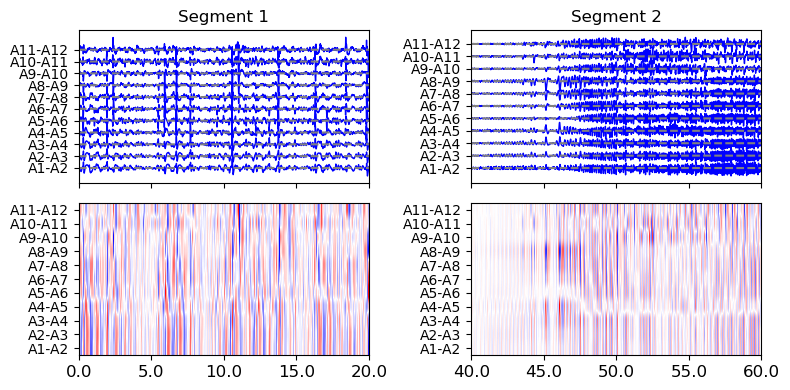

In [25]:
offset = 6

################################### Time Series
fig, ax = subplots(nrows=2, ncols=2, figsize=(8,4))

### Voltage Series
ax[0, 0].plot(data_chan_seg_1_norm + offset*arange(chans-1,-1,-1), linewidth=1, color='b');
ax[0, 0].plot(zeros((rows_seg, chans)) + offset*arange(chans-1,-1,-1),'--',color='gray');
ax[0, 0].set_yticks(offset*arange(chans))
ax[0, 0].set_yticklabels(elec_label_names)
ax[0, 0].margins(x=0)
ax[0, 0].set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_1_start)//sr, (sample_start+seg_1_stop)//sr, 5)
ax[0, 0].set_xticklabels([], fontsize=12)
ax[0, 0].set_title('Segment 1', fontsize=12)


### Voltage Heatmap
ax[1, 0].imshow(data_chan_seg_1_norm.T, aspect='auto', cmap='bwr', vmin=-3, vmax=3);
ax[1, 0].set_yticks(arange(chans))
ax[1, 0].set_yticklabels(flip(elec_label_names));

ax[1, 0].set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_1_start)//sr, (sample_start+seg_1_stop)//sr, 5)
ax[1, 0].set_xticklabels(labl, fontsize=12)


### Voltage Series
ax[0, 1].plot(data_chan_seg_2_norm + offset*arange(chans-1,-1,-1), linewidth=1, color='b');
ax[0, 1].plot(zeros((rows_seg, chans)) + offset*arange(chans-1,-1,-1),'--',color='gray');
ax[0, 1].set_yticks(offset*arange(chans))
ax[0, 1].set_yticklabels(elec_label_names)
ax[0, 1].margins(x=0)
ax[0, 1].set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_2_start)//sr, (sample_start+seg_2_stop)//sr, 5)
ax[0, 1].set_xticklabels([], fontsize=12)
ax[0, 1].set_title('Segment 2', fontsize=12)


### Voltage Heatmap
ax[1, 1].imshow(data_chan_seg_2_norm.T, aspect='auto', cmap='bwr', vmin=-3, vmax=3);
ax[1, 1].set_yticks(arange(chans))
ax[1, 1].set_yticklabels(flip(elec_label_names));

ax[1, 1].set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_2_start)//sr, (sample_start+seg_2_stop)//sr, 5)
ax[1, 1].set_xticklabels(labl, fontsize=12)


fig.tight_layout()

show()


## Correlation Matrix

As one example, we can obtain a network matrix by calculating the correlations between each pair of subjects. The resulting matrix has dimensions 11 by 11.

In [26]:
# Correlation
data_chan_seg_1_corr = corrcoef(data_chan_seg_1, rowvar=False)

fill_diagonal(data_chan_seg_1_corr, 0)

data_chan_seg_1_corr_abs      = abs(data_chan_seg_1_corr)


data_chan_seg_2_corr = corrcoef(data_chan_seg_2, rowvar=False)

fill_diagonal(data_chan_seg_2_corr, 0)

data_chan_seg_2_corr_abs      = abs(data_chan_seg_2_corr)


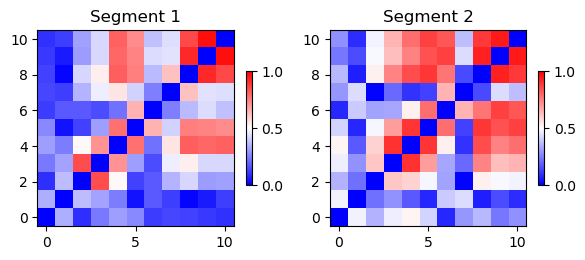

In [27]:
fig, ax = subplots(ncols=2, figsize=(6,6))

# Voltage matrices
im = ax[0].imshow(data_chan_seg_1_corr_abs, cmap='bwr', origin='lower', vmax=1);
fig.colorbar(im, ax=ax[0], ticks=(0, 0.5, 1), shrink = 0.2);
ax[0].set_title('Segment 1')

# Voltage matrices
im = ax[1].imshow(data_chan_seg_2_corr_abs, cmap='bwr', origin='lower', vmax=1);
fig.colorbar(im, ax=ax[1], ticks=(0, 0.5, 1), shrink = 0.2);
ax[1].set_title('Segment 2')

fig.tight_layout()

show()


## Thresholded Correlation Matrix

To find a pattern in the correlations we can threshold the interactions and thus obtain either a binary network matrix (entries are either 0 or 1), or a quantitative edge strength for values above the threshold. 

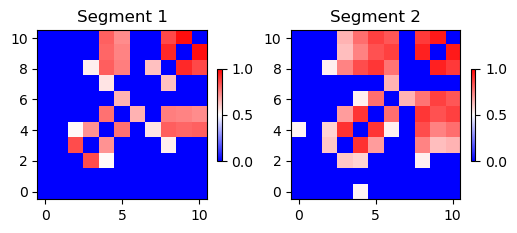

In [28]:
threshold = 0.5

data_chan_seg_1_corr_abs[abs(data_chan_seg_1_corr_abs) <= threshold] = 0
data_chan_seg_2_corr_abs[abs(data_chan_seg_2_corr_abs) <= threshold] = 0

fig, ax = subplots(ncols=2, figsize = (6, 6))

im1 = ax[0].imshow(abs(data_chan_seg_1_corr_abs), cmap='bwr', origin='lower', vmin=0, vmax=1);
ax[0].set_title('Segment 1')

fig.colorbar(im1, ax=ax[0], orientation='vertical', shrink=0.2);

im2 = ax[1].imshow(abs(data_chan_seg_2_corr_abs), cmap='bwr', origin='lower', vmin=0, vmax=1);
ax[1].set_title('Segment 2')

fig.colorbar(im2, ax=ax[1], orientation='vertical', shrink=0.2);

show()

## Construct Network from Matrix

We construct the network obtained from the above thresholded matrix, i.e. ignoring subthreshold correlations. 


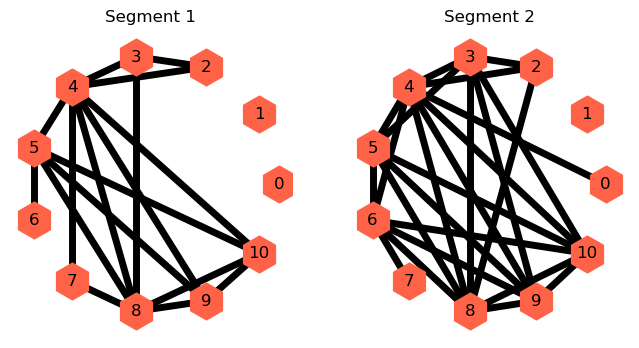

In [29]:
graph_1 = nx.Graph(data_chan_seg_1_corr_abs)
graph_2 = nx.Graph(data_chan_seg_2_corr_abs)

layout = nx.circular_layout(graph_1)

fig, ax = subplots(ncols=2, figsize=(8,4))

nx.draw(graph_1, layout, ax=ax[0],
        with_labels=True, 
        node_color='tomato', 
        node_size=700, width=5,
        node_shape='h')

nx.draw(graph_2, layout, ax=ax[1],
        with_labels=True, 
        node_color='tomato', 
        node_size=700, width=5,
        node_shape='h')


ax[0].set_title('Segment 1')
ax[1].set_title('Segment 2');

show()

In [30]:
corr_mean_1 = mean(data_chan_seg_1_corr_abs, axis=0)
corr_mean_2 = mean(data_chan_seg_2_corr_abs, axis=0)

corr_mean_1

array([0.        , 0.        , 0.12394095, 0.19069191, 0.45285698,
       0.33139218, 0.05902109, 0.10688807, 0.40904827, 0.31179842,
       0.30575334])

In [33]:
from numpy import triu_indices

# Get the indices of the correlation coefficients for 15 data columns
corr_1_coeff_indices = triu_indices(data_chan_seg_1_corr_abs.shape[0], k=1)

# Get the correlation coefficients
corr_1_coeffs = abs(data_chan_seg_1_corr_abs[corr_coeff_indices])
corr_2_coeffs = abs(data_chan_seg_2_corr_abs[corr_coeff_indices])

corr_1_coeffs.size, corr_2_coeffs.size

(55, 55)

## Advanced Display

The size of the nodes can be scaled with their mean correlation.

The size of the edges can be scaled with the correlation coefficient.

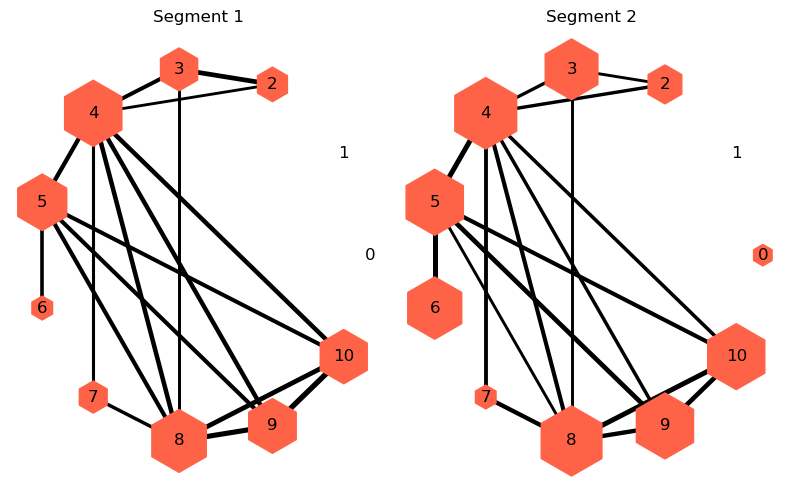

In [34]:
fig, ax = subplots(ncols=2, figsize=(8,5))

nx.draw(graph_1, layout, ax=ax[0],
        with_labels=True, 
        node_color='tomato', 
        node_size=5000*corr_mean_1, width=4*corr_1_coeffs[corr_1_coeffs > 0],
        node_shape='h')

nx.draw(graph_1, layout, ax=ax[1],
        with_labels=True, 
        node_color='tomato', 
        node_size=5000*corr_mean_2, width=4*corr_2_coeffs[corr_2_coeffs > 0],
        node_shape='h')

ax[0].set_title('Segment 1')
ax[1].set_title('Segment 2');

fig.tight_layout()

show()

Here is a 3D view of the seizure network:

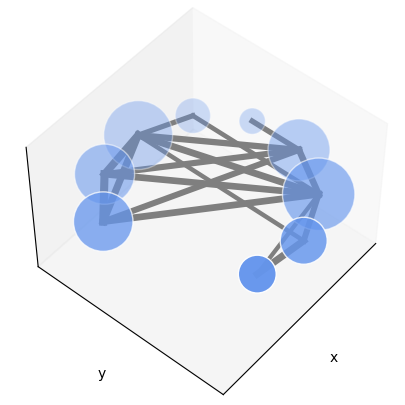

In [39]:
from mpl_toolkits.mplot3d import Axes3D

# 3D layout
pos = nx.circular_layout(graph_1, dim=3)

# Extract node and edge positions from the layout
node_xyz = array([pos[v] for v in sorted(graph_1)])
edge_xyz = array([(pos[u], pos[v]) for u, v in graph_1.edges()])

# Create the 3D figure
fig = figure(figsize=(6, 5))
ax  = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=6000*corr_mean_1, c='cornflowerblue', ec="w")

# Plot the edges
for index, vizedge in enumerate(edge_xyz):
    ax.plot(*vizedge.T, color="tab:gray", linewidth=(6*corr_1_coeffs[corr_1_coeffs > 0])[index])


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Gridlines on/off
    ax.grid(False)
    
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
        
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)

ax.view_init(50, 40);

show()

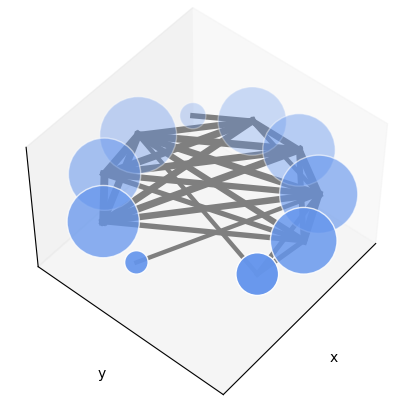

In [41]:
from mpl_toolkits.mplot3d import Axes3D

# 3D layout
pos = nx.circular_layout(graph_2, dim=3)

# Extract node and edge positions from the layout
node_xyz = array([pos[v] for v in sorted(graph_2)])
edge_xyz = array([(pos[u], pos[v]) for u, v in graph_2.edges()])

# Create the 3D figure
fig = figure(figsize=(6, 5))
ax  = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=6000*corr_mean_2, c='cornflowerblue', ec="w")

# Plot the edges
for index, vizedge in enumerate(edge_xyz):
    ax.plot(*vizedge.T, color="tab:gray", linewidth=(6*corr_2_coeffs[corr_2_coeffs > 0])[index])


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Gridlines on/off
    ax.grid(False)
    
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
        
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)

ax.view_init(50, 40);

show()

# Try it yourself

Now try segments of different lengths of the data to compare the changes in matrix properties. You can check the graph, the degrees and the clustering coefficients. 